# AML Homework 3: Practice


### Group Members:
- **Arian Gharehmohammadzadehghashghaei** (2103465)  
  [gharehmohammadzadehghashghaei.2103465@student.uniroma1.it](mailto:gharehmohammadzadehghashghaei.2103465@student.uniroma1.it)
- **Claudio Giannini** (2093898)  
  [giannini.2093898@student.uniroma1.it](mailto:giannini.2093898@student.uniroma1.it)
- **Ehsan Mokhtari** (2108539)  
  [mokhtari.2108539@studenti.uniroma1.it](mailto:mokhtari.2108539@studenti.uniroma1.it)
- **Arash Bakhshaee Babaroud** (2105709)  
  [bakhshaeebabaroud.2105709@studenti.uniroma1.it](mailto:bakhshaeebabaroud.2105709@studenti.uniroma1.it)


## Table of contents:
This notebook is composed of 7 Sections for 17 points

* **Section 1: Train a CNN from Scratch on CIFAR-10 ( 2 Points)**

    We will implement a Convolutional Neural Network (CNN) from the ground up to classify images from the CIFAR-10 dataset. The focus will be on understanding the architecture of CNNs, preprocessing the dataset, and optimizing the model to achieve high accuracy.

* **Section 2: Unlearning( 2 Points)**

    We introduce the concept of unlearning, which involves modifying a trained model to forget specific data points while retaining its overall performance.

* **Section 3: Gold model ( 2 Points)**

    We discuss the development of the Gold model, which serves as the benchmark for evaluating performance after implementing unlearning techniques. 


* **Section 4: Mia Attacks ( 3 Points)**

    This section will focus on MIA (Membership Inference Attacks), which are designed to determine whether a specific data point was included in the training set of a machine learning model. 
    
* **Section 5: Unlearning with KL divergence ( 2 Points)**

    This section will discuss the application of Kullback-Leibler (KL) divergence in the unlearning process, emphasizing its role in quantifying the difference between the model's original and modified predictions.

* **Section 6: GMN for Unlearning ( 6 Points)**

    This section will introduce the use of Graph Meta Networks (GMNs) in the unlearning process, highlighting their ability to adaptively modify model parameters based on specific unlearning tasks.

Do not modify parts of code that are not marked with "Your turn" or "Add your code below".

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from tqdm import tqdm
import os
import random
from sklearn import linear_model, model_selection
from torch_geometric.data import Data
from gmn.graph_construct.model_arch_graph import sequential_to_arch, arch_to_graph
import torch.nn.functional as F


#fix seeds
np.random.seed(0)
torch.manual_seed(0)
random.seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Section 1: Train from scratch a CNN on CIFAR-10

### 1.1: Model definition

In [2]:
def create_model():
    '''
    Create a simple CNN model for CIFAR10 dataset
    '''

    model = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=(3, 3), stride=1, padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.AvgPool2d(kernel_size=2, stride=2),
        nn.Dropout(p=0.1),

        nn.Conv2d(32, 64, kernel_size=(3, 3), stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.AvgPool2d(kernel_size=2, stride=2),
        nn.Dropout(p=0.1),

        nn.Conv2d(64, 64, kernel_size=(3, 3), stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.AdaptiveAvgPool2d((1,1)),
        nn.Flatten(),
        nn.Dropout(p=0.1),
        
        nn.Linear(64, 32),
        nn.ReLU(),
        nn.Dropout(p=0.1),
        
        nn.Linear(32, 10)
    )
    
    return model

### 1.2 DataLoader


#### Your turn ( 1 Point)

Calculate the mean and the standard deviation vectors to be used in cifar_transforms  rounding the values to four decimal places.

In [3]:
import numpy as np
from torchvision import datasets, transforms

# Load the dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())

'''
Add your code below
'''

images = torch.stack([img for img, _ in train_dataset])
mean = torch.mean(images, (0, 2, 3))
std = torch.std(images, (0, 2, 3))

print("Mean: ", np.round(mean, 4))
print("Std: ", np.round(std, 4))

Files already downloaded and verified
Mean:  tensor([0.4914, 0.4822, 0.4465])
Std:  tensor([0.2470, 0.2435, 0.2616])


In [4]:
# Define the augmentations for the training set
cifar_transforms = transforms.Compose([
    transforms.ToTensor(),                    # Convert the image to a PyTorch tensor
    transforms.Normalize(mean, std), # Normalize the image channel
])

# Load the CIFAR-10 dataset with the appropriate transforms
train_dataset = datasets.CIFAR10(root="data", train=True, transform=cifar_transforms, download=True)  
test_dataset = datasets.CIFAR10(root="data", train=False, transform=cifar_transforms, download=True)  

#split test into test and validation
val_dataset, test_dataset = torch.utils.data.random_split(test_dataset, [2000, 8000])

Files already downloaded and verified
Files already downloaded and verified


In [5]:
batch_size = 512

# Create the DataLoaders
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)

### 1.3 See the data

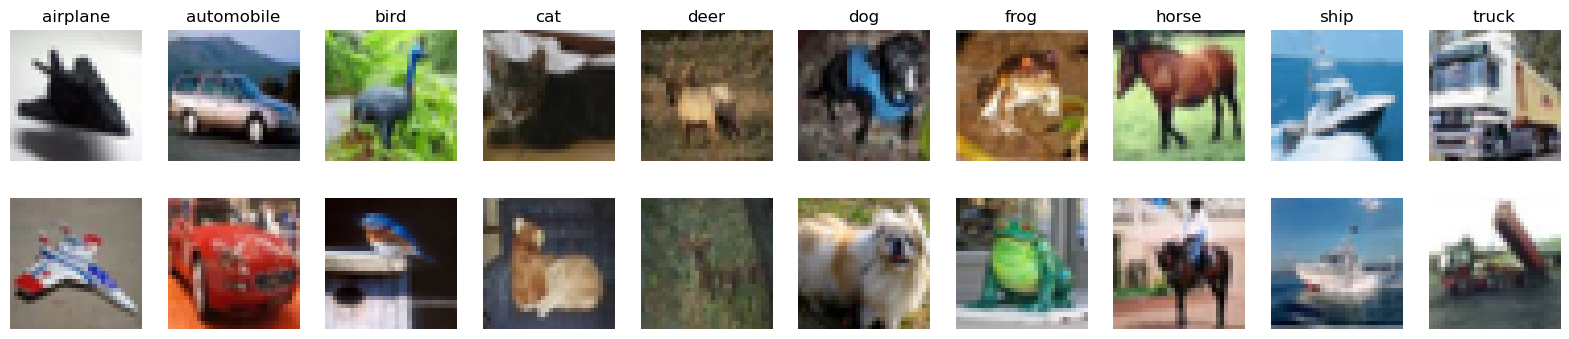

In [6]:
# plot 2 figures for each of the 10 classes in the dataset
fig, axs = plt.subplots(2, 10, figsize=(20, 4))
for i in range(10):
    # Get the first image of each class
    img = train_dataset.data[train_dataset.targets.index(i)]
    axs[0, i].imshow(img)
    axs[0, i].axis('off')
    axs[0, i].set_title(train_dataset.classes[i])

    # Get the second image of each class
    img = train_dataset.data[train_dataset.targets.index(i, train_dataset.targets.index(i) + 1)]
    axs[1, i].imshow(img)
    axs[1, i].axis('off')

### 1.4: Training Loop

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#load weights
model = create_model()
model.load_state_dict(torch.load('checkpoint/model_weights.pth'))  
model.to(device);

# initialize the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
num_epochs = 20

C:\Users\Arian\AppData\Local\Temp\ipykernel_4296\2458896940.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('checkpoint/model_weights.pt

In [8]:
# Placeholder for storing losses for each epoch
losses = []
losses_val = []

# Training the model
for epoch in range(num_epochs):

    ######### TRAINING ##########
    model.train()
    running_loss = 0  # To track loss for this epoch

    # Using tqdm for the progress bar
    loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=True)
    
    for batch_idx, (data, targets) in loop:
        # Get data to cuda if possible
        data = data.to(device=device)
        targets = targets.to(device=device)

        # Forward pass
        scores = model(data)
        loss = criterion(scores, targets)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()

        # Gradient descent step
        optimizer.step()

        # Accumulate loss
        running_loss += loss.item()

        # Update progress bar with loss and epoch information
        loop.set_description(f"Epoch [{epoch+1}/{num_epochs}]")
        loop.set_postfix(loss=loss.item())

    # Calculate average loss for the epoch
    avg_loss = running_loss / len(train_loader)
    losses.append(avg_loss)

    #scheduler 
    scheduler.step(avg_loss)

    # Print loss for this epoch
    tqdm.write(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}")

    ####### VALIDATION ########
    model.eval()
    val_loss = 0

    with torch.no_grad():
        for data, targets in val_loader:
            data = data.to(device=device)
            targets = targets.to(device=device)

            scores = model(data)
            loss = criterion(scores, targets)
            val_loss += loss.item()
        # Calculate average loss for the epoch
        avg_val_loss = val_loss / len(val_loader)
        losses_val.append(avg_val_loss)
        print(f"Validation Loss: {avg_val_loss:.4f}")
        # if avg val_loss is better than the one before, save the model
        if epoch == 0:
            # create directory if not exist
            os.makedirs("checkpoint", exist_ok=True)
            best_loss = avg_val_loss
            torch.save(model.state_dict(), "checkpoint/trained_model.pth")
        elif avg_val_loss < best_loss:
            best_loss = avg_val_loss
            torch.save(model.state_dict(), "checkpoint/trained_model.pth")

Epoch [1/20]: 100%|██████████| 98/98 [00:13<00:00,  7.26it/s, loss=1.58]


Epoch [1/20], Average Loss: 1.8913
Validation Loss: 1.5896


Epoch [2/20]: 100%|██████████| 98/98 [00:12<00:00,  8.15it/s, loss=1.38]


Epoch [2/20], Average Loss: 1.4611
Validation Loss: 1.3934


Epoch [3/20]: 100%|██████████| 98/98 [00:12<00:00,  7.87it/s, loss=1.28]


Epoch [3/20], Average Loss: 1.3152
Validation Loss: 1.2078


Epoch [4/20]: 100%|██████████| 98/98 [00:12<00:00,  7.95it/s, loss=1.17]


Epoch [4/20], Average Loss: 1.2414
Validation Loss: 1.1513


Epoch [5/20]: 100%|██████████| 98/98 [00:12<00:00,  8.11it/s, loss=1.17]


Epoch [5/20], Average Loss: 1.1901
Validation Loss: 1.2579


Epoch [6/20]: 100%|██████████| 98/98 [00:12<00:00,  7.80it/s, loss=1.18]


Epoch [6/20], Average Loss: 1.1521
Validation Loss: 1.0747


Epoch [7/20]: 100%|██████████| 98/98 [00:12<00:00,  8.07it/s, loss=1.13]


Epoch [7/20], Average Loss: 1.1180
Validation Loss: 1.0128


Epoch [8/20]: 100%|██████████| 98/98 [00:11<00:00,  8.23it/s, loss=1.06] 


Epoch [8/20], Average Loss: 1.0874
Validation Loss: 1.0277


Epoch [9/20]: 100%|██████████| 98/98 [00:12<00:00,  8.12it/s, loss=1.08] 


Epoch [9/20], Average Loss: 1.0766
Validation Loss: 1.1817


Epoch [10/20]: 100%|██████████| 98/98 [00:11<00:00,  8.18it/s, loss=1.11] 


Epoch [10/20], Average Loss: 1.0523
Validation Loss: 1.0954


Epoch [11/20]: 100%|██████████| 98/98 [00:11<00:00,  8.31it/s, loss=1]    


Epoch [11/20], Average Loss: 1.0341
Validation Loss: 0.9708


Epoch [12/20]: 100%|██████████| 98/98 [00:12<00:00,  8.16it/s, loss=0.937]


Epoch [12/20], Average Loss: 1.0233
Validation Loss: 0.9867


Epoch [13/20]: 100%|██████████| 98/98 [00:12<00:00,  8.07it/s, loss=1.09] 


Epoch [13/20], Average Loss: 1.0054
Validation Loss: 1.0316


Epoch [14/20]: 100%|██████████| 98/98 [00:11<00:00,  8.23it/s, loss=0.979]


Epoch [14/20], Average Loss: 0.9891
Validation Loss: 0.9973


Epoch [15/20]: 100%|██████████| 98/98 [00:12<00:00,  7.88it/s, loss=0.97] 


Epoch [15/20], Average Loss: 0.9759
Validation Loss: 0.8897


Epoch [16/20]: 100%|██████████| 98/98 [00:12<00:00,  7.89it/s, loss=0.915]


Epoch [16/20], Average Loss: 0.9610
Validation Loss: 0.9172


Epoch [17/20]: 100%|██████████| 98/98 [00:12<00:00,  8.00it/s, loss=1]    


Epoch [17/20], Average Loss: 0.9557
Validation Loss: 0.9075


Epoch [18/20]: 100%|██████████| 98/98 [00:12<00:00,  8.17it/s, loss=0.909]


Epoch [18/20], Average Loss: 0.9427
Validation Loss: 0.8822


Epoch [19/20]: 100%|██████████| 98/98 [00:11<00:00,  8.17it/s, loss=0.951]


Epoch [19/20], Average Loss: 0.9346
Validation Loss: 0.8242


Epoch [20/20]: 100%|██████████| 98/98 [00:12<00:00,  8.11it/s, loss=0.933]


Epoch [20/20], Average Loss: 0.9197
Validation Loss: 0.9071


Best validation loss: 0.8242


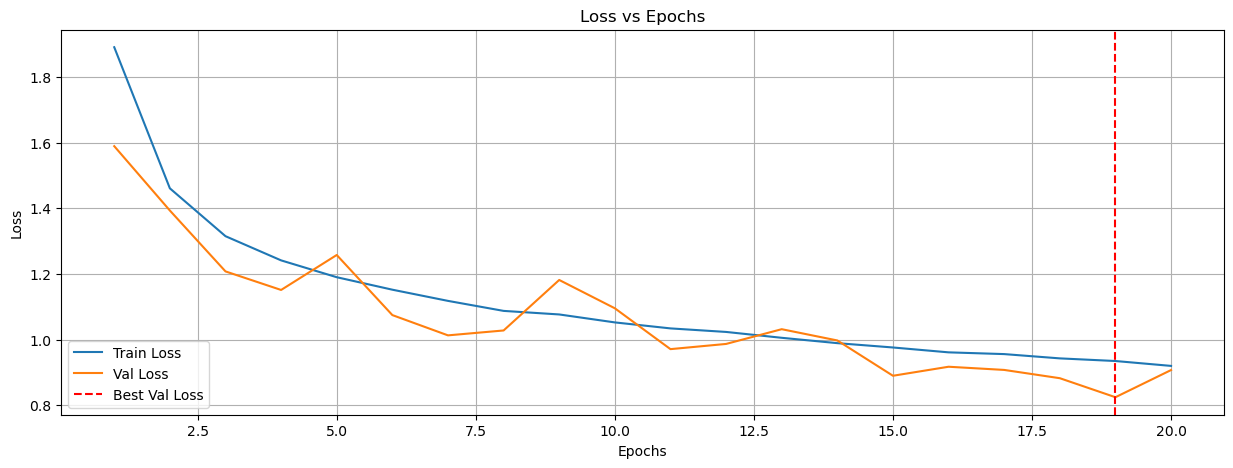

In [9]:
# Plot the losses after training
# epoch of best validation loss 
print(f"Best validation loss: {best_loss:.4f}")
index_best = losses_val.index(best_loss)

plt.figure(figsize=(15, 5))
plt.plot(range(1,num_epochs+1), losses, label="Train Loss")
plt.plot(range(1,num_epochs+1), losses_val, label="Val Loss")
plt.axvline(index_best+1, color='r', linestyle='--', label="Best Val Loss")
plt.legend()
plt.title("Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.show()

#### Your Turn (1 point)

**Question**

Q: *Based on what you've learned in the lectures and by examining the image above, identify the problems with this plot and explain how to fix them.*

A:
The model exhibits fluctuations in validation loss after epoch 10th, indicating potential overfitting or insufficient regularization. Additionally, there is a gap between training and validation losses, telling us the model is overfitting on the training data.
To address overfitting, stronger regularization methods, such as higher dropout rates and weight decay, should be implemented. Incorporating early stopping can help halt training when validation loss ceases to improve, conserving computational resources. Adjusting the learning rate schedule may also be necessary to lower the learning rate sooner when validation loss stabilizes. Finally, applying a smoothing function to the validation loss curve will improve trend visualization and reduce the impact of minor fluctuations.

### 1.5 Evaluation

Now, let's evaluate the performances of our model

In [10]:
# accuracy 
def accuracy (model, loader):
    '''
    Function to calculate the accuracy of the model on the test set
    '''
    correct = 0
    total = 0
    
    for data, targets in loader:
        data = data.to(device=device)
        targets = targets.to(device=device)
        scores = model(data)
        _, predictions = scores.max(1)
        correct += (predictions == targets).sum()
        total += targets.shape[0]
    return correct / total

In [11]:
# your model 
model = create_model()
model.load_state_dict(torch.load('checkpoint/trained_model.pth'))
model.eval()
model.to(device)

# Calculate accuracy on the train and test set 
train_accuracy = accuracy(model, train_loader)
test_accuracy = accuracy(model, test_loader)

print(f"Your Model Train Accuracy : {100* train_accuracy:.4f}")
print(f"Your Model Test Accuracy : {100* test_accuracy:.4f}")

C:\Users\Arian\AppData\Local\Temp\ipykernel_4296\4085122296.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('checkpoint/trained_model.pt

Your Model Train Accuracy : 72.2560
Your Model Test Accuracy : 70.6500


To avoid training for too many epochs, here it is a checkpoint you can use for the trained model.

In [12]:
model = create_model()
model.load_state_dict(torch.load("checkpoint/best_model.pth"))
model.eval()
model.to(device)

# Calculate the accuracy on the train and test set
train_accuracy = accuracy(model, train_loader)
test_accuracy = accuracy(model, test_loader)

print(f"Train accuracy: {100* train_accuracy:.4f}")
print(f"Test Accuracy: {100* test_accuracy:.4f}")

C:\Users\Arian\AppData\Local\Temp\ipykernel_4296\2030750594.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("checkpoint/best_model.pth")

Train accuracy: 86.3900
Test Accuracy: 80.9125


# Section 2: Unlearning 

In the context of machine learning, unlearning refers to the process of modifying a trained model so that it forgets specific pieces of information without losing the general performance. This is particularly important in situations where data privacy is a concern, such as when sensitive information is involved, or when a model has learned from outdated or incorrect data. In this scenario, 
you may want to unlearn an entire class of data, a specific instance within that class, or even a particular concept that the model has learned. 

**Why is Unlearning Important?**

Let’s say you have trained a machine learning model to recognize different types of animals based on a dataset containing images. Now, suppose that this dataset includes images of a particular cat breed that was later found to be misclassified or problematic. You might need to remove that specific information from the model to ensure it doesn't make incorrect predictions in the future.

Additionally, with privacy laws like GDPR (General Data Protection Regulation), individuals have the right to request that their personal data be removed from a model. If a model has been trained on this data, we need a way to unlearn it.

Here, our task will be to unlearn the class of Airplanes in CIFAR-10 Dataset

### Unlearning by Fine-Tuning 

The Unlearning by Fine-Tuning strategy is a technique used to remove the influence of specific data points from a trained machine learning model while preserving its performance on other, relevant data. 
Here’s a detailed explanation of how this strategy works:

#### 1. The Retain Set

The retain set consists of all the data points that you want the model to remember or continue to learn from. This set excludes the data points you want the model to forget.

####  2. Fine-Tuning Process

To perform unlearning through this strategy, you follow these steps:

- Identify and Remove the Data Points: First, identify the data points that you wish to unlearn and remove them from the training dataset.

- Prepare the Retain and Forget Set: Create a new training dataset that contains only the retain set, those data points that should be kept in the model’s knowledge, and include the remaing data in the Forget Set.

- Fine-Tuning on the Retain Set: Instead of retraining the model from scratch, you will fine-tune the existing model using the retain set. This involves using the retain set to continue training the model, typically with a lower learning rate to ensure that the model can adjust its parameters without drastically altering what it has already learned.

#### 3. Benefits of this strategy

- Efficiency: Fine-tuning on the retain set only is more efficient than retraining the model from scratch. It saves computational resources and time.

- Maintained Performance: The model retains its ability to perform well on the general dataset, as it continues to learn from the valid data in the retain set.

#### 4. Drawbacks of this strategy

- Even if more efficient than retraining the model from scratch, you still need to do a fine tuning, that could be very expensive for large or foundational models. Even finding the best hyperparameters can be costly.

- If you change samples or architecture to unlearn, you have to do the ad-hoc fine tuning again, it is not a *general* strategy.

### 2.1: Forget Airplanes

#### Your Turn ( 1 Point)

Generate the retain and forget datasets, keeping in mind that we want to forget the "airplanes" class. Afterward, create new instances of the loaders for training, validation, and testing. Make sure to use the torch.utils.data.Subset function.

In [13]:
#train
'''
Add your code below
'''

class_names = train_dataset.classes
label_to_class = {i: class_name for i, class_name in enumerate(class_names)}
print("Label to Class Mapping:", label_to_class) # To check which label to delete

retain_indices_train, forget_indices_train = [], []
for i in range(len(train_dataset)):
    if train_dataset[i][1] != 0:  # Retain non-airplane classes
        retain_indices_train.append(i)
    else:  # Forget airplane class
        forget_indices_train.append(i)

retain_dataset = torch.utils.data.Subset(train_dataset, retain_indices_train)
forget_dataset = torch.utils.data.Subset(train_dataset, forget_indices_train)
retain_loader = DataLoader(retain_dataset, batch_size=batch_size)
forget_loader = DataLoader(forget_dataset, batch_size=batch_size)

print('retain_dataset length: ', len(retain_dataset), 'forget_dataset length: ', len(forget_dataset))

Label to Class Mapping: {0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}
retain_dataset length:  45000 forget_dataset length:  5000


In [14]:
#validation
'''
Add your code below
'''

retain_idx, forget_idx = [], []
for idx in range(len(val_dataset)):
    label = val_dataset[idx][1]
    if label != 0:  # Non-airplane class
        retain_idx.append(idx)
    else:  # Airplane class
        forget_idx.append(idx)

retain_dataset_val = torch.utils.data.Subset(val_dataset, retain_idx)
forget_dataset_val = torch.utils.data.Subset(val_dataset, forget_idx)

retain_loader_val = DataLoader(dataset=retain_dataset_val, batch_size=batch_size, shuffle=False)
forget_loader_val = DataLoader(dataset=forget_dataset_val, batch_size=batch_size, shuffle=False)

print('retain_dataset_val length: ', len(retain_dataset_val), 'forget_dataset_val length: ', len(forget_dataset_val))

retain_dataset_val length:  1800 forget_dataset_val length:  200


In [15]:
#test 
'''
Add your code below
'''

retain_indices_test, forget_indices_test = [], []
for idx in range(len(test_dataset)):
    if test_dataset[idx][1] != 0:  # Classes to retain
        retain_indices_test.append(idx)
    else:  # Classes to forget
        forget_indices_test.append(idx)

retain_dataset_test = torch.utils.data.Subset(test_dataset, retain_indices_test)
forget_dataset_test = torch.utils.data.Subset(test_dataset, forget_indices_test)

retain_loader_test = DataLoader(dataset=retain_dataset_test, batch_size=batch_size, shuffle=True)
forget_loader_test = DataLoader(dataset=forget_dataset_test, batch_size=batch_size, shuffle=True)

print('retain_dataset_test length: ', len(retain_dataset_test), 'forget_dataset_test length: ', len(forget_dataset_test))

retain_dataset_test length:  7200 forget_dataset_test length:  800


### 2.2: Training Loop

In [16]:
def unlearning( model, retain_loader , validation, epochs = 5, criterion = criterion, optimizer = optimizer, scheduler = scheduler):
    """Unlearning by fine-tuning.

    Fine-tuning is a very simple algorithm that trains using only
    the retain set.

    Args:
      model : nn.Module.
        pre-trained model to use as base of unlearning.
      retain : torch.utils.data.DataLoader.
        Dataset loader for access to the retain set. This is the subset
        of the training set that we don't want to forget.
      validation : torch.utils.data.DataLoader.
        Dataset loader for access to the validation set. This method doesn't
        make use of the validation set.
    Returns:
      model : updated model
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    losses = []
    losses_val = []
   
    for epoch in range(epochs):
        model.train()
        loss_epoch = 0
        loop = tqdm(enumerate(retain_loader), total=len(retain_loader), leave=True)
        for batch_idx, (inputs, targets) in loop:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            #running loss
            loss_epoch += loss.item()
            # Update progress bar with loss and epoch information
            loop.set_description(f"Epoch [{epoch+1}/{epochs}]")
            loop.set_postfix(loss=loss.item())

        #avg loss
        avg_loss = loss_epoch / len(retain_loader )
        losses.append(avg_loss)
        #scheduler step
        scheduler.step(avg_loss)
        tqdm.write(f"Epoch [{epoch+1}/{epochs}], Average Loss: {avg_loss:.4f}")

        # validation
        loss_val = 0
        model.eval()
        with torch.no_grad():
            for data, targets in retain_loader_val:
                data = data.to(device=device)
                targets = targets.to(device=device)

                scores = model(data)
                loss = criterion(scores, targets)
                loss_val += loss.item()
            # Calculate average loss for the epoch
            avg_val_loss = loss_val / len(validation)
            losses_val.append(avg_val_loss)
            print(f"Validation Loss: {avg_val_loss:.4f}")
            # if avg val_loss is better than the one before, save the model
            if epoch == 0:
                # create directory if not exist
                os.makedirs("checkpoint", exist_ok=True)
                best_loss = avg_val_loss
                torch.save(model.state_dict(), "checkpoint/forget_model.pth")
            elif avg_val_loss < best_loss:
                best_loss = avg_val_loss
                torch.save(model.state_dict(), "checkpoint/forget_model.pth")
        
                
    model.eval()
    model.load_state_dict(torch.load("checkpoint/forget_model.pth"))
    return model, losses, losses_val

In [17]:
# intialize forget model as trained model
forget_model = create_model()
forget_model.load_state_dict(torch.load("checkpoint/best_model.pth"))

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(forget_model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)


# Unlearn the forget set
epochs = 10
forget_model, losses, losses_val = unlearning(forget_model, retain_loader, val_loader, epochs=epochs, criterion=criterion, optimizer=optimizer, scheduler=scheduler)

C:\Users\Arian\AppData\Local\Temp\ipykernel_4296\302344697.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  forget_model.load_state_dict(torch.load("checkpoint/best_model

Epoch [1/10], Average Loss: 0.5244
Validation Loss: 0.5125


Epoch [2/10]: 100%|██████████| 88/88 [00:11<00:00,  7.95it/s, loss=0.46] 


Epoch [2/10], Average Loss: 0.5035
Validation Loss: 0.5092


Epoch [3/10]: 100%|██████████| 88/88 [00:11<00:00,  7.93it/s, loss=0.463]


Epoch [3/10], Average Loss: 0.4994
Validation Loss: 0.5055


Epoch [4/10]: 100%|██████████| 88/88 [00:11<00:00,  7.73it/s, loss=0.45] 


Epoch [4/10], Average Loss: 0.4955
Validation Loss: 0.4978


Epoch [5/10]: 100%|██████████| 88/88 [00:12<00:00,  7.31it/s, loss=0.475]


Epoch [5/10], Average Loss: 0.4932
Validation Loss: 0.4969


Epoch [6/10]: 100%|██████████| 88/88 [00:11<00:00,  7.70it/s, loss=0.449]


Epoch [6/10], Average Loss: 0.4895
Validation Loss: 0.5006


Epoch [7/10]: 100%|██████████| 88/88 [00:11<00:00,  7.49it/s, loss=0.445]


Epoch [7/10], Average Loss: 0.4897
Validation Loss: 0.4960


Epoch [8/10]: 100%|██████████| 88/88 [00:11<00:00,  7.77it/s, loss=0.41] 


Epoch [8/10], Average Loss: 0.4845
Validation Loss: 0.4998


Epoch [9/10]: 100%|██████████| 88/88 [00:10<00:00,  8.01it/s, loss=0.437]


Epoch [9/10], Average Loss: 0.4874
Validation Loss: 0.4957


Epoch [10/10]: 100%|██████████| 88/88 [00:10<00:00,  8.29it/s, loss=0.42] 


Epoch [10/10], Average Loss: 0.4815
Validation Loss: 0.4973


C:\Users\Arian\AppData\Local\Temp\ipykernel_4296\4194831512.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("checkpoint/forget_model.pt

**Below there is the evaluation of your unlearned by fine-tuning model**

In [18]:
# load weights forget model
forget_model = create_model()
forget_model.load_state_dict(torch.load("checkpoint/forget_model.pth"));
forget_model.eval()
forget_model.to(device);

# print accuracies on retain, forget and test set
retain_accuracy = accuracy(forget_model, retain_loader)
forget_accuracy = accuracy(forget_model, forget_loader)
test_accuracy = accuracy(forget_model, test_loader)
test_accuracy_retain = accuracy(forget_model, retain_loader_test)
test_accuracy_forget = accuracy(forget_model, forget_loader_test)

print(f"Retain set Accuracy: {100* retain_accuracy:.4f}")
print(f"Forget set Accuracy: {100* forget_accuracy:.4f}")
print(f"Test set Accuracy: {100* test_accuracy:.4f}") # whole test set
print(f"Test set Retain Accuracy: {100* test_accuracy_retain:.4f}")
print(f"Test set Forget Accuracy: {100* test_accuracy_forget:.4f}")

C:\Users\Arian\AppData\Local\Temp\ipykernel_4296\1861309560.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  forget_model.load_state_dict(torch.load("checkpoint/forget_mo

Retain set Accuracy: 88.6844
Forget set Accuracy: 34.0600
Test set Accuracy: 77.3750
Test set Retain Accuracy: 83.0556
Test set Forget Accuracy: 26.2500


#### Your Turn (1 Point)

**Question**

Q: *Summarize what you have learned. Specifically, interpret the accuracy values for the retain and forget sets during training. Additionally, discuss what can be inferred from the accuracy at test time for the entire test set, as well as for the two subsets of forget and retain.*

A: Fine-tuning for unlearning involves retraining a model on the retain set (excluding the class to be forgotten) to reduce its specialization for the forgotten class. The fine-tuned model achieves 88.68% accuracy on the retain set, slightly better than the original model, demonstrating effective retention of knowledge. The test accuracy drops slightly to 77.37%, an acceptable tradeoff given the goal of unlearning.

On the test subsets, the retain accuracy remains high at 83.05%, while the forget accuracy drops to 26.25%, showing that the model effectively “forgets” the target class. This happens because the model never encounters the forgotten class during fine-tuning, forcing it to specialize further in the remaining classes without learning anything meaningful for the forgotten class.

# Section 3: Gold model

One might ask, how good are the scores above? What is the best possible score? Since our goal is to approximate a model that has been trained **only on** the retain set, we'll consider that the gold standard is the score achieved by this model. Such a model is called here the *gold model*.

In [19]:
# train only on retain set
gold_model = create_model()
gold_model.load_state_dict(torch.load("checkpoint/model_weights.pth"))
gold_model.to(device);

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(gold_model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
num_epochs = 20

C:\Users\Arian\AppData\Local\Temp\ipykernel_4296\4189939539.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  gold_model.load_state_dict(torch.load("checkpoint/model_weigh

#### Your Turn ( 1 Point)

Implement the training loop for the Gold Model. Store you losses inside the ```losses``` and ```losses_val``` lists.

**IMPORTANT: save the best checkpoint of this model to a checkpoint file called "checkpoint/gold_model.pth"**

In [20]:
# **IMPORTANT: save the best checkpoint of this model to a checkpoint file called "checkpoint/gold_model.pth"**
'''
Add your code below
'''

losses = []
losses_val = []

for epoch in range(num_epochs):
    epoch_loss = 0
    gold_model.train()
    for inputs, labels in tqdm(retain_loader, total=len(retain_loader), leave=True):
        
        inputs = inputs.to(device)
        labels = labels.to(device)

        pred = gold_model(inputs)
        loss = criterion(pred, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(retain_loader)
    losses.append(avg_loss)
    
    scheduler.step(avg_loss)
    tqdm.write(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}")

    loss_val = 0
    gold_model.eval()
    with torch.no_grad():
        for inputs, labels in retain_loader_val:
            inputs = inputs.to(device)
            labels = labels.to(device)

            pred = gold_model(inputs)
            loss = criterion(pred, labels)
            loss_val += loss.item()
        
        avg_val_loss = loss_val / len(retain_loader_val)
        losses_val.append(avg_val_loss)
        print(f"Validation Loss: {avg_val_loss:.4f}")
        
        if epoch == 0:
            os.makedirs("checkpoint", exist_ok=True)
            best_loss = avg_val_loss
            torch.save(gold_model.state_dict(), "checkpoint/gold_model.pth")
        elif avg_val_loss < best_loss:
            best_loss = avg_val_loss
            torch.save(gold_model.state_dict(), "checkpoint/gold_model.pth")

100%|██████████| 88/88 [00:10<00:00,  8.28it/s]


Epoch [1/20], Average Loss: 2.2304
Validation Loss: 2.1486


100%|██████████| 88/88 [00:10<00:00,  8.15it/s]


Epoch [2/20], Average Loss: 2.0958
Validation Loss: 2.0071


100%|██████████| 88/88 [00:10<00:00,  8.11it/s]


Epoch [3/20], Average Loss: 1.9564
Validation Loss: 1.8601


100%|██████████| 88/88 [00:10<00:00,  8.17it/s]


Epoch [4/20], Average Loss: 1.8231
Validation Loss: 1.7361


100%|██████████| 88/88 [00:10<00:00,  8.24it/s]


Epoch [5/20], Average Loss: 1.7124
Validation Loss: 1.6392


100%|██████████| 88/88 [00:10<00:00,  8.61it/s]


Epoch [6/20], Average Loss: 1.6229
Validation Loss: 1.5562


100%|██████████| 88/88 [00:09<00:00,  8.90it/s]


Epoch [7/20], Average Loss: 1.5500
Validation Loss: 1.4819


100%|██████████| 88/88 [00:10<00:00,  8.47it/s]


Epoch [8/20], Average Loss: 1.4841
Validation Loss: 1.4302


100%|██████████| 88/88 [00:10<00:00,  8.27it/s]


Epoch [9/20], Average Loss: 1.4311
Validation Loss: 1.3899


100%|██████████| 88/88 [00:10<00:00,  8.06it/s]


Epoch [10/20], Average Loss: 1.3842
Validation Loss: 1.3496


100%|██████████| 88/88 [00:10<00:00,  8.51it/s]


Epoch [11/20], Average Loss: 1.3472
Validation Loss: 1.3230


100%|██████████| 88/88 [00:10<00:00,  8.16it/s]


Epoch [12/20], Average Loss: 1.3161
Validation Loss: 1.2782


100%|██████████| 88/88 [00:10<00:00,  8.21it/s]


Epoch [13/20], Average Loss: 1.2860
Validation Loss: 1.2843


100%|██████████| 88/88 [00:10<00:00,  8.55it/s]


Epoch [14/20], Average Loss: 1.2602
Validation Loss: 1.2273


100%|██████████| 88/88 [00:11<00:00,  7.64it/s]


Epoch [15/20], Average Loss: 1.2416
Validation Loss: 1.2204


100%|██████████| 88/88 [00:10<00:00,  8.05it/s]


Epoch [16/20], Average Loss: 1.2198
Validation Loss: 1.1819


100%|██████████| 88/88 [00:10<00:00,  8.37it/s]


Epoch [17/20], Average Loss: 1.2044
Validation Loss: 1.1817


100%|██████████| 88/88 [00:10<00:00,  8.76it/s]


Epoch [18/20], Average Loss: 1.1906
Validation Loss: 1.1691


100%|██████████| 88/88 [00:11<00:00,  7.61it/s]


Epoch [19/20], Average Loss: 1.1763
Validation Loss: 1.1492


100%|██████████| 88/88 [00:10<00:00,  8.33it/s]


Epoch [20/20], Average Loss: 1.1639
Validation Loss: 1.1205


Best validation loss: 1.1205


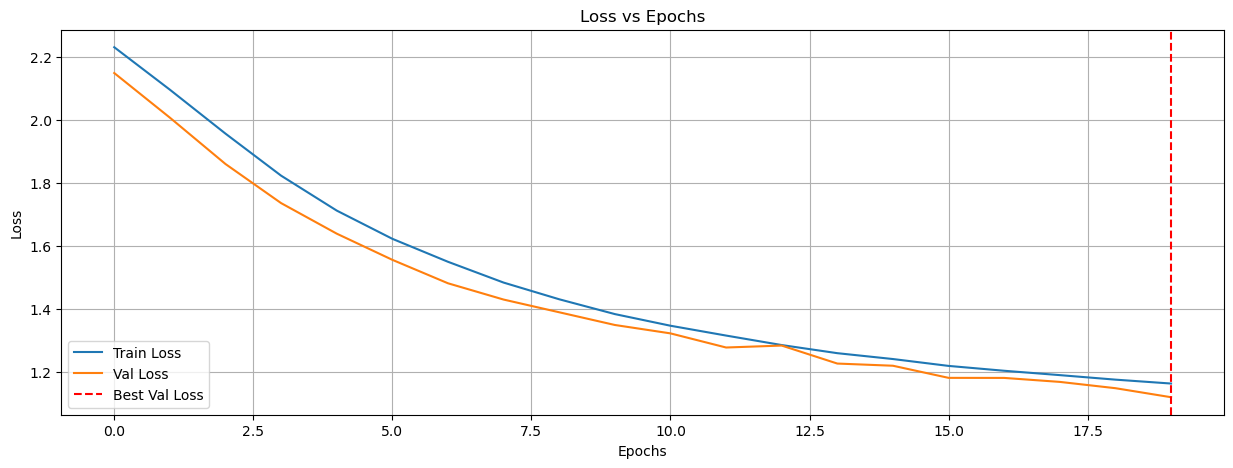

In [21]:
#epoch of best validation loss 
print(f"Best validation loss: {best_loss:.4f}")
index_best = losses_val.index(best_loss)

plt.figure(figsize=(15, 5))
plt.plot(losses, label="Train Loss")
plt.plot(losses_val, label="Val Loss")
plt.axvline(index_best, color='r', linestyle='--', label="Best Val Loss")
plt.legend()
plt.title("Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.show()

**Below there is the evaluation of the gold model**

In [22]:
# load weights gold model
gold_model = create_model()
gold_model.load_state_dict(torch.load("checkpoint/gold_model.pth"))
gold_model.eval()
gold_model.to(device);

# print accuracies on retain, forget and test set
retain_accuracy = accuracy(gold_model, retain_loader)
forget_accuracy = accuracy(gold_model, forget_loader)
test_accuracy = accuracy(gold_model, test_loader)
test_accuracy_retain = accuracy(gold_model, retain_loader_test)
test_accuracy_forget = accuracy(gold_model, forget_loader_test)

print(f"Retain set Accuracy: {100* retain_accuracy:.4f}")
print(f"Forget set Accuracy: {100* forget_accuracy:.4f}")
print(f"Test set Accuracy: {100* test_accuracy:.4f}")
print(f"Test set Retain Accuracy: {100* test_accuracy_retain:.4f}")
print(f"Test set Forget Accuracy: {100* test_accuracy_forget:.4f}")

C:\Users\Arian\AppData\Local\Temp\ipykernel_4296\2111462457.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  gold_model.load_state_dict(torch.load("checkpoint/gold_model.

Retain set Accuracy: 59.1267
Forget set Accuracy: 0.0000
Test set Accuracy: 52.8750
Test set Retain Accuracy: 58.7500
Test set Forget Accuracy: 0.0000


#### Your Turn

**Question**

Q: *Explain the results of the Gold Model. Did you notice something strange?*

A: The forget set (both in training and testing) achieves an accuracy of 0%. This is because the model learns to avoid predicting the class corresponding to the forgotten label, as no samples with that label were included in training and consequently, the output tensor of 10 elements never assigns meaningful probabilities to the first position, corresponding to the 'airplane' class. OVerall accuracy is lower but it's expected since it includes the forget dataset which has 0% accuracy. Finally the retain set (Both in train and test) has a relatively lower accuracy.

# Section 5: Mia attacks

In this section, we'll quantify the quality of the unlearning algorithm through a simple membership inference attack (MIA).
MIAs are a type of adversarial attack aimed at determining whether a specific data point was included in the training dataset of a machine learning model. These attacks exploit the behavior of the model to make inferences about the presence or absence of certain data points.
This MIA consists of a logistic regression model that predicts whether the model was trained on a particular sample from that sample's loss.



In [23]:
def compute_losses(model, loader, criterion = "CrossEntropy"):

    """
    Auxiliary function to compute per-sample losses
    Args:
    model : model to evaluate
    loader : data loader
    criterion : loss function. Specify "CrossEntropy" for cross-entropy loss or "KL" for KL divergence
    """

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    all_losses = []

    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)
        logits = model(inputs)
        losses = nn.CrossEntropyLoss(reduction = "none")(logits, targets).detach().cpu().numpy()
   
        for l in losses:
            all_losses.append(l)

    return np.array(all_losses)

In [24]:
#model
model = create_model()
model.load_state_dict(torch.load("checkpoint/best_model.pth"));
model.eval()
model.to(device);

retain_losses = compute_losses(model, retain_loader_test)
forget_losses = compute_losses(model, forget_loader_test)

C:\Users\Arian\AppData\Local\Temp\ipykernel_4296\1836622987.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("checkpoint/best_model.pth")

In [25]:
# forget model
forget_model = create_model()
forget_model.load_state_dict(torch.load("checkpoint/forget_model.pth"));
forget_model.eval()
forget_model.to(device);

retain_losses_forget = compute_losses(forget_model, retain_loader_test)
forget_losses_forget = compute_losses(forget_model, forget_loader_test)

C:\Users\Arian\AppData\Local\Temp\ipykernel_4296\1859805898.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  forget_model.load_state_dict(torch.load("checkpoint/forget_mo

In [26]:
# gold model
gold_model = create_model()
gold_model.load_state_dict(torch.load("checkpoint/gold_model.pth"));
gold_model.eval()
gold_model.to(device);

retain_losses_gold = compute_losses(gold_model, retain_loader_test)
forget_losses_gold = compute_losses(gold_model, forget_loader_test)

C:\Users\Arian\AppData\Local\Temp\ipykernel_4296\3701508357.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  gold_model.load_state_dict(torch.load("checkpoint/gold_model.

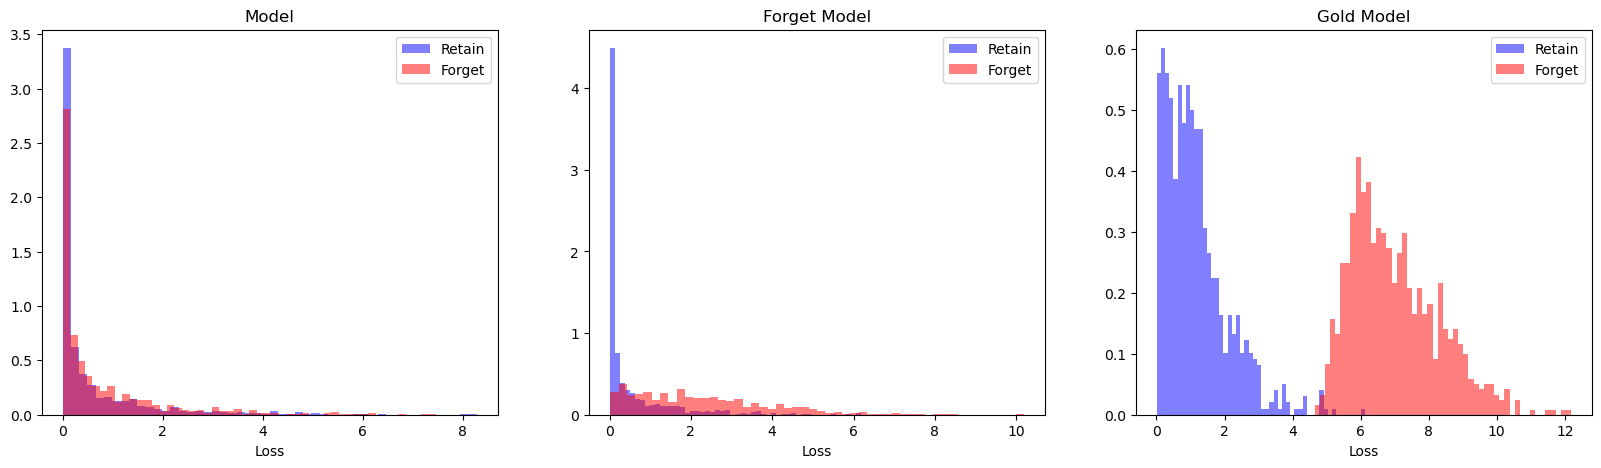

In [27]:
# 3 plots woth ax of histograms
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

#subsample retrain losses to have the same size as the forget losses
random_idx = np.random.choice(np.arange(len(retain_losses)), len(forget_losses), replace=False)
retain_losses = retain_losses[random_idx]
retain_losses_forget = retain_losses_forget[random_idx]
retain_losses_gold = retain_losses_gold[random_idx]


axs[0].hist(retain_losses, density = True, bins=50, alpha=0.5, label='Retain', color='blue')
axs[0].hist(forget_losses, density = True, bins=50, alpha=0.5, label='Forget', color='red')
axs[0].set_title('Model')
axs[0].set_xlabel('Loss')
axs[0].legend()

axs[1].hist(retain_losses_forget, density = True, bins=50, alpha=0.5, label='Retain', color='blue')
axs[1].hist(forget_losses_forget, density = True, bins=50, alpha=0.5, label='Forget', color='red')
axs[1].set_title('Forget Model')
axs[1].set_xlabel('Loss')
axs[1].legend()

axs[2].hist(retain_losses_gold, density = True, bins=50, alpha=0.5, label='Retain', color='blue')
axs[2].hist(forget_losses_gold, density = True, bins=50, alpha=0.5, label='Forget', color='red')
axs[2].set_title('Gold Model')
axs[2].set_xlabel('Loss')
axs[2].legend()

plt.show()

In [28]:
def simple_mia(sample_loss, members, n_splits=10, random_state=0):
    """Computes cross-validation score of a membership inference attack.

    Args:
      sample_loss : array_like of shape (n,).
        objective function evaluated on n samples.
      members : array_like of shape (n,),
        whether a sample was used for training.
      n_splits: int
        number of splits to use in the cross-validation.
    Returns:
      scores : array_like of size (n_splits,)
    """
    
    torch.manual_seed(torch.initial_seed())
    
    unique_members = np.unique(members)
    if not np.all(unique_members == np.array([0, 1])):
        raise ValueError("members should only have 0 and 1s")

    attack_model = linear_model.LogisticRegression(random_state=random_state)
    cv = model_selection.StratifiedShuffleSplit(
        n_splits=n_splits, random_state = 0
    )
    
    return model_selection.cross_val_score(
        attack_model, sample_loss, members, cv=cv, scoring="accuracy", 
    )

In [29]:
# mia on model
retain_losses_subsample = np.random.choice(retain_losses, len(forget_losses), replace=False)
samples_mia = np.concatenate([retain_losses_subsample, forget_losses]).reshape(-1, 1)
#balance the number of samples
members_mia = np.concatenate([np.zeros(len(retain_losses_subsample)), np.ones(len(forget_losses))])

scores_model = simple_mia(samples_mia, members_mia)
print(f"Model MIA score: {scores_model.mean():.4f}")

Model MIA score: 0.5513


In [30]:
#mia on forget model
retain_losses_forget_subsample = np.random.choice(retain_losses_forget, len(forget_losses_forget), replace=False)
samples_mia = np.concatenate([retain_losses_forget_subsample, forget_losses_forget]).reshape(-1, 1)
members_mia = np.concatenate([np.zeros(len(retain_losses_forget_subsample)), np.ones(len(forget_losses_forget))])

scores_forget = simple_mia(samples_mia, members_mia)
print(f"Forget Model MIA score: {scores_forget.mean():.4f}")

Forget Model MIA score: 0.7769


In [31]:
# mia on gold model
retain_losses_gold_subsample = np.random.choice(retain_losses_gold, len(forget_losses_gold), replace=False)
samples_mia = np.concatenate([retain_losses_gold_subsample, forget_losses_gold]).reshape(-1, 1)
members_mia = np.concatenate([np.zeros(len(retain_losses_gold_subsample)), np.ones(len(forget_losses_gold))])

scores_gold = simple_mia(samples_mia, members_mia)
print(f"Gold Model MIA score: {scores_gold.mean():.4f}")

Gold Model MIA score: 0.9925


#### Your Turn ( 3 Points)

**Question**

Q: *For each model, analyze the loss plots and explain the results obtained from the membership inference attack (MIA).*

A: The loss plots illustrate the performance of three models on the Retain and Forget sets. The first model (best_model) shows balanced performance on both sets, which is expected since it has been trained to recognize both. The second model (forget_model) performs better on the Retain set, as it has been specifically trained to forget the Forget set. Lastly, the third model (gold_model) exhibits a significant disparity between the loss values on the Retain and Forget sets.

In the context of Membership Inference Attacks (MIA), the attack exploits these differences in loss values to determine whether a data point was part of the model’s training set. As anticipated, the MIA model’s performance correlates with the diversity in losses between the two sets:
- The best_model shows similar loss values for both sets, making it difficult for the MIA model to distinguish between them, resulting in an accuracy of around 0.56 (basically random guessing).
-	The forget_model displays a larger gap between the losses on the two sets, with data from the Forget set typically having lower loss values. This distinction helps the MIA model improve its accuracy.
-	The gold_model has a striking difference in loss values between the Retain and Forget sets. In this case, identifying whether a data point was part of the training set becomes almost trivial — if the loss exceeds roughly 4.5, it’s likely from the Forget set. Consequently, the MIA model performs almost flawlessly, achieving close to 100% accuracy.

# 6. Unlearning with Kl divergence


The Kullback-Leibler (KL) divergence is a measure of how one probability distribution differs from another. In this case, to induce unlearning, we want the model's predictions on the forget set to match a uniform distribution, meaning the model "forgets" any specific information about these classes.

#### Your Turn (1 Point) 

Next, consider a simple scenario to clarify the concept: a classification problem with four classes. Here, the objective is to unlearn one class by enforcing the logits' distribution (after the softmax) to match a uniform distribution. In this case, let the target distribution for a sample coming from the forget set be $y_{gt} = [0.25, 0.25, 0.25, 0.25]$, and assume that you have achieved the predicted distribution $y_{pred} = [0.25, 0.25, 0.25, 0.25]$

**Question**

Q: *In this context, why is it preferable to use KL divergence instead of Cross-Entropy? Explain it and fill the code below in order to show it numerically.*

A: In the context of unlearning, where the goal is to make the model's predictions on the forget set resemble a uniform distribution (e.g., [0.25, 0.25, 0.25, 0.25]), KL divergence is a better choice than Cross-Entropy. Cross-Entropy is commonly used in classification tasks to measure the difference between the target (usually one-hot encoded) and the predicted distributions. However, when the target is a uniform distribution, Cross-Entropy does not align naturally with the idea of "forgetting," as its primary purpose is to boost confidence in correct predictions. KL Divergence, in contrast, is specifically designed to measure how far one distribution (such as the predicted one) is from another (like the uniform target distribution). This makes it a more suitable metric for unlearning, as the goal is to ensure the model’s predictions are as close to a uniform distribution as possible. By focusing on KL Divergence, the model effectively forgets any class preferences, producing a distribution that is indistinguishable from a uniform one. Cross-Entropy, on the other hand, can penalize predictions differently, making it less aligned with the forgetting process.

In [32]:
y_gt = torch.tensor([0.25, 0.25, 0.25, 0.25])  
y_pred = torch.tensor([0.25, 0.25, 0.25, 0.25])

'''
Add your code below
'''
cross_entropy = F.cross_entropy(y_pred.unsqueeze(0), torch.argmax(y_gt).unsqueeze(0))
kl_div = F.kl_div(y_pred.log(), y_gt, reduction="batchmean")

print(f"Cross Entropy: {cross_entropy:.4f}")
print(f"KL Divergence: {kl_div:.4f}")

Cross Entropy: 1.3863
KL Divergence: 0.0000


**Question**

Q: *Before proceeding, you should explain the relationship between Cross-Entropy and Kullback-Leibler (KL) divergence. Provide the proof showing how to derive the relationship between the two.*

Answer:

To derive the relationship, start with the KL divergence formula:
$[
D_{\text{KL}}(P \| Q) = \sum_{y} P(y) \log \frac{P(y)}{Q(y)}
$]
Expand the fraction inside the logarithm:
$[
D_{\text{KL}}(P \| Q) = \sum_{y} P(y) \left[ \log P(y) - \log Q(y) \right]
$]
Distribute \(P(y)\):
$[
D_{\text{KL}}(P \| Q) = \sum_{y} P(y) \log P(y) - \sum_{y} P(y) \log Q(y)
$]
The first term, $(- \sum_{y} P(y) \log P(y)$), is the **entropy** of \(P\), denoted as \(H(P)\). The second term, $(- \sum_{y} P(y) \log Q(y)$), is the **cross-entropy** between \(P\) and \(Q\), denoted as \(H(P, Q)\). Substituting:
$[
D_{\text{KL}}(P \| Q) = H(P, Q) - H(P)
$]
Thus, the KL divergence is the difference between the cross-entropy and the entropy of \(P\).

In [33]:
#fix seeds
np.random.seed(0)
torch.manual_seed(0)
random.seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [34]:
def make_target (target, number_of_classes = 10):
    '''
    Function to modify the target class
    '''
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    tensor = torch.nn.functional.one_hot(target, num_classes= number_of_classes ).float().to(device)
    # Identify rows with 1 in the first position
    first_pos_mask = target == 0
    
    # Substite the rows with 1 in the first position with a uniform distribution
    n = tensor.size(1)  # Numero di colonne
    uniform_distribution = torch.full((n,), 1.0 / n, device = device)  # Distribuzione uniforme
    tensor[first_pos_mask] = uniform_distribution

    return tensor

In [35]:
def unlearning_2 (model, forget_loader, validation, epochs, optimizer, scheduler):
    '''
    Function to unlearn the forget set
    '''
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    epsilon = 1e-5
    model.to(device)
    losses = []
    losses_val = []
    
    for epoch in range(epochs):
        model.train()
        loss_epoch = 0
        loop = tqdm(enumerate(forget_loader), total=len(forget_loader), leave=True)
        for batch_idx, (inputs, targets) in loop:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            outputs = outputs + epsilon
            outputs = F.log_softmax(outputs, dim=1)
            
            targets = make_target(targets)
            loss = F.kl_div(outputs, targets, reduction='batchmean')
            loss.backward()
            optimizer.step()

            #running loss
            loss_epoch += loss.item()
            # Update progress bar with loss and epoch information
            loop.set_description(f"Epoch [{epoch+1}/{epochs}]")
            loop.set_postfix(loss=loss.item())

        #avg loss
        avg_loss = loss_epoch / len(forget_loader )
        losses.append(avg_loss)
        #scheduler step
        scheduler.step(avg_loss)
        tqdm.write(f"Epoch [{epoch+1}/{epochs}], Average Loss: {avg_loss:.4f}")

        # validation
        loss_val = 0
        model.eval()
        with torch.no_grad():
            for data, targets in validation:
                data = data.to(device=device)
                targets = targets.to(device=device)

                scores = model(data)
                scores = scores + epsilon
                scores = F.log_softmax(scores, dim=1)
                targets = make_target(targets)
                loss = F.kl_div(scores, targets, reduction='batchmean')
                loss_val += loss.item()
            # Calculate average loss for the epoch
            avg_val_loss = loss_val / len(validation)
            losses_val.append(avg_val_loss)
            print(f"Validation Loss: {avg_val_loss:.4f}")
            # if avg val_loss is better than the one before, save the model
            if epoch == 0:
                # create directory if not exist
                os.makedirs("checkpoint", exist_ok=True)
                best_loss = avg_val_loss
                torch.save(model.state_dict(), "checkpoint/another_forget_model.pth")
            elif avg_val_loss < best_loss:
                best_loss = avg_val_loss
                torch.save(model.state_dict(), "checkpoint/another_forget_model.pth")
    return model, losses, losses_val

In [36]:
another_forget_model = create_model()
another_forget_model.load_state_dict(torch.load("checkpoint/best_model.pth"));
another_forget_model.to(device);

# optimizer
optimizer = torch.optim.Adam(another_forget_model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
num_epochs = 10

forget_loader = forget_loader
val_loader = forget_loader_val

another_forget_model, losses, losses_val = unlearning_2(another_forget_model, forget_loader, val_loader, num_epochs, optimizer, scheduler)

C:\Users\Arian\AppData\Local\Temp\ipykernel_4296\266061249.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  another_forget_model.load_state_dict(torch.load("checkpoint/be

Epoch [1/10], Average Loss: 1.6866
Validation Loss: 1.4904


Epoch [2/10]: 100%|██████████| 10/10 [00:01<00:00,  7.58it/s, loss=1.16]


Epoch [2/10], Average Loss: 1.2966
Validation Loss: 1.0807


Epoch [3/10]: 100%|██████████| 10/10 [00:01<00:00,  7.34it/s, loss=0.93]


Epoch [3/10], Average Loss: 1.0472
Validation Loss: 0.8648


Epoch [4/10]: 100%|██████████| 10/10 [00:01<00:00,  7.48it/s, loss=0.81]


Epoch [4/10], Average Loss: 0.8766
Validation Loss: 0.7213


Epoch [5/10]: 100%|██████████| 10/10 [00:01<00:00,  7.79it/s, loss=0.689]


Epoch [5/10], Average Loss: 0.7498
Validation Loss: 0.6157


Epoch [6/10]: 100%|██████████| 10/10 [00:01<00:00,  7.60it/s, loss=0.584]


Epoch [6/10], Average Loss: 0.6486
Validation Loss: 0.5351


Epoch [7/10]: 100%|██████████| 10/10 [00:01<00:00,  8.00it/s, loss=0.524]


Epoch [7/10], Average Loss: 0.5727
Validation Loss: 0.4748


Epoch [8/10]: 100%|██████████| 10/10 [00:01<00:00,  7.97it/s, loss=0.471]


Epoch [8/10], Average Loss: 0.5115
Validation Loss: 0.4233


Epoch [9/10]: 100%|██████████| 10/10 [00:01<00:00,  7.82it/s, loss=0.418]


Epoch [9/10], Average Loss: 0.4561
Validation Loss: 0.3781


Epoch [10/10]: 100%|██████████| 10/10 [00:01<00:00,  8.14it/s, loss=0.384]

Epoch [10/10], Average Loss: 0.4142
Validation Loss: 0.3463


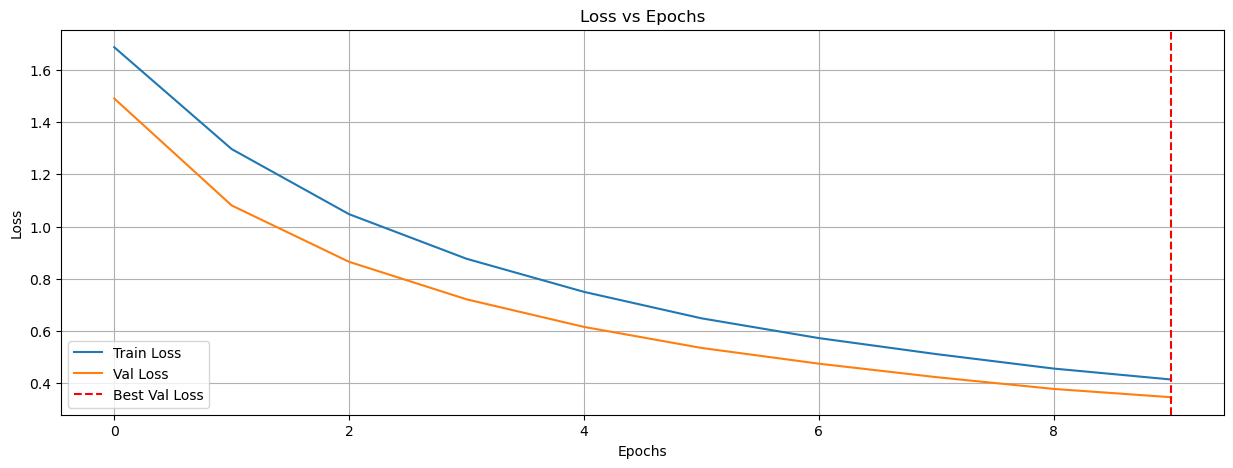

In [37]:
#plot losses
#epoch of best validation loss
index_best = losses_val.index(min(losses_val))

plt.figure(figsize=(15, 5))
plt.plot(losses, label="Train Loss")
plt.plot(losses_val, label="Val Loss")
plt.axvline(index_best, color='r', linestyle='--', label="Best Val Loss")
plt.legend()
plt.title("Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.show()

In [38]:
# calculate accuracy 
another_forget_model = create_model()
another_forget_model.load_state_dict(torch.load("checkpoint/another_forget_model.pth"))
another_forget_model.eval()
another_forget_model.to(device)


# Calculate the accuracy on the test set
retain_accuracy = accuracy(another_forget_model, retain_loader)
forget_accuracy = accuracy(another_forget_model, forget_loader)
test_accuracy = accuracy(another_forget_model, test_loader)
retain_test_accuracy = accuracy(another_forget_model, retain_loader_test)
forget_test_accuracy = accuracy(another_forget_model, forget_loader_test)

C:\Users\Arian\AppData\Local\Temp\ipykernel_4296\2802900956.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  another_forget_model.load_state_dict(torch.load("checkpoint/a

In [39]:
# print accuracies on retain, forget and test set
print(f"Retain Accuracy: {100* retain_accuracy:.4f}")
print(f"Forget Accuracy: {100* forget_accuracy:.4f}")
print(f"Test Accuracy: {100* test_accuracy:.4f}")
print(f"Test Retain Accuracy: {100* retain_test_accuracy:.4f}")
print(f"Test Forget Accuracy: {100* forget_test_accuracy:.4f}")

Retain Accuracy: 64.2222
Forget Accuracy: 15.9600
Test Accuracy: 56.5000
Test Retain Accuracy: 61.1944
Test Forget Accuracy: 14.2500


In [40]:
# calculate losses of the model on forget and retain test set
retain_losses_CE = compute_losses(another_forget_model, retain_loader_test)
forget_losses_CE = compute_losses(another_forget_model, forget_loader_test)

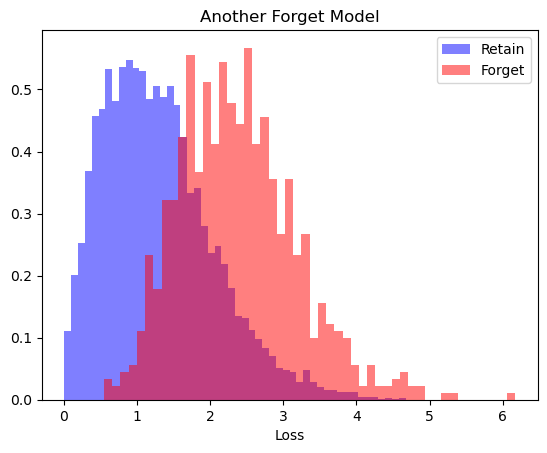

In [41]:
plt.hist(retain_losses_CE, density = True, bins=50, alpha=0.5, label='Retain', color='blue')
plt.hist(forget_losses_CE, density = True, bins=50, alpha=0.5, label='Forget', color='red')
plt.title('Another Forget Model')
plt.xlabel('Loss')
plt.legend()
plt.show()

In [42]:
# mia attack on cross entropy
np.random.seed(0)
subsample_retain_losses_CE = np.random.choice(retain_losses_CE, len(forget_losses), replace=False)
samples_mia = np.concatenate([subsample_retain_losses_CE, forget_losses_CE]).reshape(-1, 1)
members_mia = np.concatenate([np.zeros(len(subsample_retain_losses_CE)), np.ones(len(forget_losses))])

scores_another_forget = simple_mia(samples_mia, members_mia)
print(f"Another Forget Model MIA score with Cross Entropy losses: {scores_another_forget.mean():.4f}")

Another Forget Model MIA score with Cross Entropy losses: 0.7712


This is another way of performing unlearning, you may have noticed that the distributions of the retain and forget sets are different but still there is an overlapping portion. It is very likely that the MIA attack will fail in that specific region.

# GMN for unlearning (6 Points)

Now, we will attempt to use the GMN you have implemented in the theory notebook for the unlearning task. Keep in mind that this is a novel and challenging task, and it is quite possible that the results may not meet your expectations. However, this is the nature of research. Therefore, the evaluation will focus on the clarity of your approach and your ability to justify your choices and results, rather then the result itself.

First of all, go into the ```Practice/gmn/graph_models.py``` file and replace the empty classes with what you have implemented in the second part of the theory notebook. Then, try to think about and implement an unlearning algorithm that leverages the graph metanetwork, and evaluate the unlearned model with MIA attacks and accuracy scores. It would be super cool to have a neural network (the GMN) that can take as input other pretrained neural networks and produce as output the same networks but unlearned over a specific subset of data samples.

In the end, generate a detailed report where you describe your idea, methodology and implementation. Put the most of your effort in explaining us the ideas and the intuitions that you had, since this is what we will reward. Don't be worried if results are poor, there can be many causes of this and it's not your task to solve all of them.

In [43]:
from gmn.graph_models import *
from torch_geometric.data import Data, Batch
from gmn.graph_construct.model_arch_graph import sequential_to_arch, arch_to_graph, graph_to_arch, arch_to_sequential
from gmn.feature_extractor_gmn import NodeEdgeFeatEncoder
from gmn.graph_models import MPNN

torch.manual_seed(0)

weights = torch.load("checkpoint/best_model.pth")
model = create_model()
model.load_state_dict(weights)
arch = sequential_to_arch(model)
x, edge_index, edge_attr = arch_to_graph(arch)
x = x.float()
edge_attr = edge_attr.float()

# currently u is a vector of zeros, and it is basically useless. You can consider filling it with what you prefer and leverage it for the task of unlearning
g_cnn = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, u = torch.zeros(1, 8))

graph_batch = Batch.from_data_list([g_cnn])
print(graph_batch)

DataBatch(x=[216, 3], edge_index=[2, 59050], edge_attr=[59050, 6], u=[1, 8], batch=[216], ptr=[2])


C:\Users\Arian\AppData\Local\Temp\ipykernel_4296\954954823.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load("checkpoint/best_model.pth")


In [44]:
class GraphMetaNetwork(nn.Module):
    '''
    Wrapper class for the graph metanetwork
    '''
    def __init__(self, encoder, mpnn):
        super(GraphMetaNetwork, self).__init__()
        self.encoder = encoder
        self.mpnn = mpnn

    def forward(self, data):
        x, edge_index, edge_attr, u, batch = data.x, data.edge_index, data.edge_attr, data.u, data.batch
        x, edge_attr = self.encoder(x, edge_attr)
        x, edge_attr, u = self.mpnn(x, edge_index, edge_attr, u, batch)
        return edge_attr

# Define the encoder and MPNN
pre_embedding_dim = 64
global_in_dim = 8
hidden_dim = 32
node_out_dim = 3
edge_out_dim = 1
global_out_dim = 8
num_gnn_layers = 4
encoder = NodeEdgeFeatEncoder(hidden_dim=pre_embedding_dim)
mpnn = MPNN(node_in_dim=pre_embedding_dim,
            edge_in_dim=pre_embedding_dim,
            global_in_dim = global_in_dim,
            hidden_dim=hidden_dim,
            node_out_dim= node_out_dim,
            edge_out_dim = edge_out_dim,
            global_out_dim= global_out_dim,
            num_layers=num_gnn_layers,
            reduce='mean')

# Create the metanetwork
gmn = GraphMetaNetwork(encoder, mpnn)
gmn.to(device)

GraphMetaNetwork(
  (encoder): NodeEdgeFeatEncoder(
    (node_layer_encoder): Sequential(
      (0): Linear(in_features=1, out_features=64, bias=True)
      (1): Sin()
    )
    (neuron_num_encoder): Sequential(
      (0): Linear(in_features=1, out_features=64, bias=True)
      (1): Sin()
    )
    (node_type_encoder): Embedding(17, 64)
    (x_proj): Linear(in_features=192, out_features=64, bias=True)
    (weight_encoder): Sequential(
      (0): Linear(in_features=1, out_features=64, bias=True)
      (1): Sin()
    )
    (edge_layer_encoder): Sequential(
      (0): Linear(in_features=1, out_features=64, bias=True)
      (1): Sin()
    )
    (conv_pos_encoder): Sequential(
      (0): Linear(in_features=3, out_features=64, bias=True)
      (1): Sin()
    )
    (edge_type_encoder): Embedding(14, 64)
    (edge_attr_proj): Linear(in_features=256, out_features=64, bias=True)
  )
  (mpnn): MPNN(
    (convs): ModuleList(
      (0): MetaLayer(
        edge_model=EdgeModel(
        (edge_mlp): S

## Report

The unlearning process is structured into four stages:
- First, the architecture of the pretrained neural network was represented by the professor as a graph, capturing all attributes such as weights, biases, and layer connections.
- Second, we fine-tune the GMN using only the retained dataset, ensuring the model adapts without the influence of the data to be unlearned.
- Third, we transform the updated graph back into a neural network, effectively implementing the unlearning.
- Finally, we evaluate the unlearned model’s performance using metrics such as accuracy and Membership Inference Attack (MIA) susceptibility to assess its efficacy.

This structured methodology provides a systematic approach to implementing and evaluating unlearning in neural networks.

If you need to convert the output of the gmn back into a neural network model (i.e., an ```nn.Sequential``` object), please look into ```graph_to_arch``` and ```arch_to_sequential``` functions stored in ```Practice/gmn/graph_construct/model_arch_graph.py```.

### Fine-Tuning the GMN only using the retrain_dataset

We fine-tuned the Graph MetaNetwork (GMN) to enable the forgetting of the airplane class by exclusively training the GMN on the retain dataset, which consists of data excluding samples from the airplane class. This approach ensures that the model updates its parameters while focusing solely on the data that should be retained, effectively minimizing the model’s reliance on features and representations tied to the airplane class. By doing so, the model undergoes a targeted unlearning process, where it adapts to perform well on the retain dataset while mitigating the influence of the forgotten class. 

In [45]:
from torch.utils.data import Dataset

class CIFARGraphDataset(Dataset):
    def __init__(self, dataset, label_to_class, graph_transform=None):
        self.dataset = dataset
        self.label_to_class = label_to_class
        self.graph_transform = graph_transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]

        x, edge_index, edge_attr = self.convert_to_graph(image)

        # Create a placeholder for global features (u), e.g., a zero tensor
        u = torch.zeros(1, 8)  # Adjust the size of u as needed

        if self.graph_transform:
            x, edge_index, edge_attr = self.graph_transform(x, edge_index, edge_attr)

        # Return the graph data along with the label and global feature u
        graph_data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=label, u=u)
        return graph_data

    def convert_to_graph(self, image):
        H, W = 32, 32  # CIFAR-10 image size

        # Each pixel is a node (flatten the image to a 1D vector of pixels)
        x = image.view(-1, 3)  # Shape: [H*W, 3]

        # Create dummy edges, assuming grid connectivity (you can modify this)
        edge_index = torch.tensor([[], []], dtype=torch.long)
        edge_attr = torch.tensor([], dtype=torch.float)

        return x, edge_index, edge_attr

In [46]:
# Create Graph-based datasets from the CIFAR data
retain_graph_dataset = CIFARGraphDataset(retain_dataset, label_to_class)
forget_graph_dataset = CIFARGraphDataset(forget_dataset, label_to_class)

# Now, you can create data loaders
retain_loader_gmn = DataLoader(retain_graph_dataset, batch_size=batch_size, shuffle=True)
forget_loader_gmn = DataLoader(forget_graph_dataset, batch_size=batch_size, shuffle=True)

print('retain_dataset length:', len(retain_loader_gmn), 'forget_dataset length:', len(forget_loader_gmn))

retain_dataset length: 88 forget_dataset length: 10


In [47]:
def train_model(model, retain_loader, forget_loader, optimizer, criterion, epochs=10):
    model.train()  # Set model to training mode
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")

        # Training on Retain Dataset
        for batch_idx, batch in enumerate(retain_loader):
            # Move data to device
            batch = batch.to(device)

            optimizer.zero_grad()

            out = model(batch)

            # Compute loss
            loss = criterion(out, batch.y)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            if batch_idx % 10 == 0:
                print(f"Batch {batch_idx}/{len(retain_loader)}: Retain Loss = {loss.item()}")

    return model

# Now fine-tune the model
fine_tuned_model = train_model(gmn, retain_loader_gmn, forget_loader_gmn, optimizer, criterion, epochs=5)

Epoch 1/5


TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'torch_geometric.data.data.Data'>

* we couldnt solve the error but that we expected a similar low accuracy as in our first model (30%) and a MIA score in between 0.7 and 0.8

### Graph to Arch, Arch to Sequential

In this section, we leverage the graph_to_arch function to reconstruct a neural network architecture from the updated graph representation. Specifically, we transform the graph’s nodes, edges, and global attributes—each representing the model’s structural and parameterized elements—back into a functional architecture. Subsequently, we use the arch_to_sequential function to convert the reconstructed architecture into a PyTorch nn.Sequential model, making it compatible with standard deep learning workflows.

In [48]:
# After fine-tuning the GMN, save the updated graph representation
torch.save({
    "x": graph_batch.x,
    "edge_index": graph_batch.edge_index,
    "edge_attr": edge_attr
}, "checkpoint/forget_model_gmn.pth")

In [ ]:
graph_data = torch.load("checkpoint/updated_graph.pth")
x = graph_data["x"]
edge_index = graph_data["edge_index"]
edge_attr = graph_data["edge_attr"]

# Use the loaded graph representation to reconstruct the architecture
reconstructed_arch = graph_to_arch(x, edge_index, edge_attr)

# Convert the reconstructed architecture back to a PyTorch sequential model
reconstructed_model = arch_to_sequential(reconstructed_arch)

# Save or evaluate the reconstructed model
torch.save(reconstructed_model.state_dict(), "checkpoint/reconstructed_forget_model_gmn.pth")

### Evaluate Forget Model GMN

In this section, we evaluate the performance of the reconstructed_forget_model_gmn after unlearning the specified class. The model is tested on several datasets: the retain set; the forget set, where the model should ideally show reduced performance, indicating successful unlearning of the forgotten class; and the test set, which evaluates the generalization of the model. We compute and print accuracy metrics for both the retain and forget classes in the test set, as well as overall test performance, to assess the model’s ability to retain relevant knowledge while forgetting the target class.

In [ ]:
reconstructed_model = create_model()
reconstructed_model.load_state_dict(torch.load("checkpoint/reconstructed_forget_model_gmn.pth"))
reconstructed_model.eval()
reconstructed_model.to(device)

retain_accuracy = accuracy(reconstructed_model, retain_loader)
forget_accuracy = accuracy(reconstructed_model, forget_loader)
test_accuracy = accuracy(reconstructed_model, test_loader)
retain_test_accuracy = accuracy(reconstructed_model, retain_loader_test)
forget_test_accuracy = accuracy(reconstructed_model, forget_loader_test)

print(f"Retain Accuracy: {100 * retain_accuracy:.4f}%")
print(f"Forget Accuracy: {100 * forget_accuracy:.4f}%")
print(f"Test Accuracy: {100 * test_accuracy:.4f}%")
print(f"Test Retain Accuracy: {100 * retain_test_accuracy:.4f}%")
print(f"Test Forget Accuracy: {100 * forget_test_accuracy:.4f}%")

#### MIA

In this section, we perform a Membership Inference Attack (MIA) on the newly reconstructed model.

In [ ]:
# Calculate losses on the forget and retain test sets using the new reconstructed model
retain_losses = compute_losses(reconstructed_model, retain_loader_test)
forget_losses = compute_losses(reconstructed_model, forget_loader_test)

# Plot the histogram of the losses for the retain and forget sets
plt.hist(retain_losses, density=True, bins=50, alpha=0.5, label='Retain', color='blue')
plt.hist(forget_losses, density=True, bins=50, alpha=0.5, label='Forget', color='red')
plt.title('Reconstructed Forget Model - Loss Distribution')
plt.xlabel('Loss')
plt.ylabel('Density')
plt.legend()
plt.show()

In [ ]:
# MIA Attack on the new model using Cross-Entropy losses
np.random.seed(0)

subsample_retain_losses = np.random.choice(retain_losses, len(forget_losses), replace=False)
samples_mia = np.concatenate([subsample_retain_losses, forget_losses]).reshape(-1, 1)

# Labels for MIA: 0 for retain (not seen during training) and 1 for forget (seen during training)
members_mia = np.concatenate([np.zeros(len(subsample_retain_losses)), np.ones(len(forget_losses))])

# Perform the MIA attack using the simple_mia function
scores_new_model = simple_mia(samples_mia, members_mia)
print(f"New Model MIA score with Cross Entropy losses: {scores_new_model.mean():.4f}")